<a href="https://colab.research.google.com/github/charlaburnett/dc_heat_analysis/blob/main/dc_heat_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import numpy as np
import rasterio

def calculate_lst_dual(tif_path):
    with rasterio.open(tif_path) as src:
        lst_dn = src.read(1).astype("float32")
        profile = src.profile

        lst_dn = np.where(lst_dn > 0, lst_dn, np.nan)


        lst_kelvin = (lst_dn * 0.00341802) + 149.0
        lst_celsius = lst_kelvin - 273.15
        lst_fahrenheit = (lst_celsius * 9 / 5) + 32

    return lst_celsius, lst_fahrenheit, profile


# 2015
lst_c_2015, lst_f_2015, prof_2015 = calculate_lst_dual(
    "/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/LC08_L2SP_015033_20150614_20201015_02_T1_ST_B10.TIF"
)

# 2025
lst_c_2025, lst_f_2025, prof_2025 = calculate_lst_dual(
    "/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/LC08_L2SP_015033_20250625_20250701_02_T1_ST_B10.TIF"
)



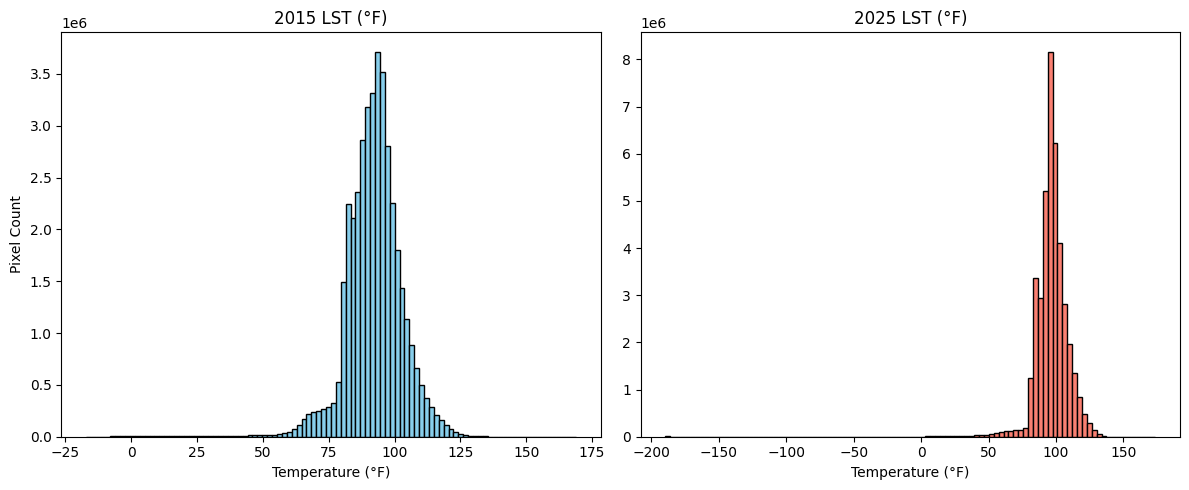

In [38]:
import matplotlib.pyplot as plt

# Flatten and remove NaNs
lst_2015_flat = lst_f_2015[~np.isnan(lst_f_2015)].flatten()
lst_2025_flat = lst_f_2025[~np.isnan(lst_f_2025)].flatten()

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(lst_2015_flat, bins=100, color="skyblue", edgecolor="black")
plt.title("2015 LST (°F)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Pixel Count")

plt.subplot(1, 2, 2)
plt.hist(lst_2025_flat, bins=100, color="salmon", edgecolor="black")
plt.title("2025 LST (°F)")
plt.xlabel("Temperature (°F)")

plt.tight_layout()
plt.show()


In [39]:
from scipy.stats import shapiro

# Take random sample (e.g., 5000 non-NaN values)
sample_2015 = np.random.choice(lst_2015_flat, size=5000, replace=False)
sample_2025 = np.random.choice(lst_2025_flat, size=5000, replace=False)

stat_2015, p_2015 = shapiro(sample_2015)
stat_2025, p_2025 = shapiro(sample_2025)

print(f"2015 Shapiro-Wilk p-value: {p_2015:.5f}")
print(f"2025 Shapiro-Wilk p-value: {p_2025:.5f}")


2015 Shapiro-Wilk p-value: 0.00000
2025 Shapiro-Wilk p-value: 0.00000


In [40]:
from scipy.stats import skew, kurtosis

print(f"2015 Skew: {skew(lst_2015_flat):.2f}, Kurtosis: {kurtosis(lst_2015_flat):.2f}")
print(f"2025 Skew: {skew(lst_2025_flat):.2f}, Kurtosis: {kurtosis(lst_2025_flat):.2f}")


2015 Skew: -1.37, Kurtosis: 9.24
2025 Skew: -5.90, Kurtosis: 91.67


In [ ]:
import rasterio
from rasterio.features import shapes
import geopandas as gpd

dc_clipped = "/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/nlcd_2024_dc_clipped.tif"

with rasterio.open(dc_clipped) as src:
    band = src.read(1)
    mask = band != src.nodata

    results = (
        {"properties": {"nlcd_code": int(v)}, "geometry": s}
        for s, v in shapes(band, mask=mask, transform=src.transform)
    )

    gdf = gpd.GeoDataFrame.from_features(list(results), crs=src.crs)

def classify_uhi(code):
    if code in [21, 22, 23, 24]:
        return "Urban"
    elif code in [41, 42, 43, 52]:
        return "Vegetation"
    elif code == 11:
        return "Water"
    else:
        return "Other"

gdf["uhi_class"] = gdf["nlcd_code"].apply(classify_uhi)

output_path = "/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_landcover_polygons.shp"
gdf.to_file(output_path)

print(f"Saved classified land cover shapefile to:\n{output_path}")


In [ ]:
from rasterstats import zonal_stats
import geopandas as gpd
import rasterio

landcover_gdf = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_landcover_polygons.shp")

with rasterio.open("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/lst_2015_celsius.tif") as src_2015:
    landcover_2015 = landcover_gdf.to_crs(src_2015.crs)

# Zonal statistics
stats_2015 = zonal_stats(
    vectors=landcover_2015,
    raster="/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/lst_2015_celsius.tif",
    stats=["mean"],
    geojson_out=True
)

# Convert to GeoDataFrame
gdf_2015 = gpd.GeoDataFrame.from_features(stats_2015)
gdf_2015.set_crs(src_2015.crs, inplace=True)

gdf_2015.to_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_stats_2015.shp")
print("Saved 2015 zonal stats shapefile.")


In [ ]:
with rasterio.open("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/lst_2015_celsius.tif") as src_2025:
    landcover_2025 = landcover_gdf.to_crs(src_2025.crs)

stats_2025 = zonal_stats(
    vectors=landcover_2025,
    raster="/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/lst_2025_celsius.tif",
    stats=["mean"],
    geojson_out=True
)

gdf_2025 = gpd.GeoDataFrame.from_features(stats_2025)
gdf_2025.set_crs(src_2025.crs, inplace=True)
gdf_2025.to_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_stats_2025.shp")
print("Saved 2025 zonal stats shapefile.")


In [ ]:
gdf_2015 = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_stats_2015.shp")
gdf_2025 = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_stats_2025.shp")

gdf_2015 = gdf_2015.to_crs(epsg=4326)
gdf_2025 = gdf_2025.to_crs(epsg=4326)

comparison = gdf_2015[["geometry", "mean"]].copy()
comparison = comparison.rename(columns={"mean": "mean_2015"})
comparison["mean_2025"] = gdf_2025["mean"]
comparison["temp_change"] = comparison["mean_2025"] - comparison["mean_2015"]

comparison_path = "/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_change_2015_2025.shp"
comparison.to_file(comparison_path)
print(f"Saved temp change shapefile to:\n{comparison_path}")


In [ ]:
import leafmap
import geopandas as gpd

comparison = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_change_2015_2025.shp")
comparison = comparison.to_crs(epsg=4326)
comparison = comparison.dropna(subset=["mean_2015", "mean_2025", "temp_chang"])

m = leafmap.Map(center=[38.9, -77.0], zoom=12)

m.add_data(
    comparison,
    column="mean_2015",
    cmap="YlOrRd",
    layer_name="LST 2015 (°C)",
    legend_title="2015 Mean Temp (°C)",
    style={"weight": 0.2, "fillOpacity": 0.6}
)

m.add_data(
    comparison,
    column="mean_2025",
    cmap="YlOrRd",
    layer_name="LST 2025 (°C)",
    legend_title="2025 Mean Temp (°C)",
    style={"weight": 0.2, "fillOpacity": 0.6}
)

m.add_data(
    comparison,
    column="temp_chang",
    cmap="coolwarm",
    layer_name="Temp Change (°C)",
    legend_title="Temp Change (2025 - 2015 °C)",
    style={"weight": 0.2, "fillOpacity": 0.7}
)

m.add_layer_control()

m


In [ ]:
from rasterstats import zonal_stats
import geopandas as gpd
import rasterio

landcover_gdf = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_landcover_polygons.shp")

# --- 2015 ---
with rasterio.open("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/lst_2015_fahrenheit.tif") as src_2015:
    landcover_2015 = landcover_gdf.to_crs(src_2015.crs)

stats_2015_f = zonal_stats(
    vectors=landcover_2015,
    raster="/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/lst_2015_fahrenheit.tif",
    stats=["mean"],
    geojson_out=True
)

gdf_2015_f = gpd.GeoDataFrame.from_features(stats_2015_f)
gdf_2015_f.set_crs(src_2015.crs, inplace=True)
gdf_2015_f.to_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_stats_2015_f.shp")

# --- 2025 ---
with rasterio.open("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat//lst_2025_fahrenheit.tif") as src_2025:
    landcover_2025 = landcover_gdf.to_crs(src_2025.crs)

stats_2025_f = zonal_stats(
    vectors=landcover_2025,
    raster="/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/lst_2025_fahrenheit.tif",
    stats=["mean"],
    geojson_out=True
)

gdf_2025_f = gpd.GeoDataFrame.from_features(stats_2025_f)
gdf_2025_f.set_crs(src_2025.crs, inplace=True)
gdf_2025_f.to_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_stats_2025_f.shp")


In [ ]:
import geopandas as gpd

gdf_2015_f = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_stats_2015_f.shp")
gdf_2025_f = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_stats_2025_f.shp")

if gdf_2015_f.crs is None:
    gdf_2015_f.set_crs(epsg=32618, inplace=True)
if gdf_2025_f.crs is None:
    gdf_2025_f.set_crs(epsg=32618, inplace=True)

gdf_2015_f = gdf_2015_f.to_crs(epsg=4326)
gdf_2025_f = gdf_2025_f.to_crs(epsg=4326)

comparison_f = gdf_2015_f[["geometry", "mean"]].copy()
comparison_f = comparison_f.rename(columns={"mean": "mean_2015_f"})
comparison_f["mean_2025_f"] = gdf_2025_f["mean"]
comparison_f["temp_change_f"] = comparison_f["mean_2025_f"] - comparison_f["mean_2015_f"]

comparison_f.to_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_change_2015_2025_fahrenheit.shp")


In [ ]:
import geopandas as gpd
import leafmap
from scipy.stats import zscore

# Load shapefile
comparison = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_change_2015_2025_fahrenheit.shp")
comparison = comparison.to_crs(epsg=4326)

# Drop nulls
comparison_clean = comparison.dropna(subset=["mean_2015_", "mean_2025_", "temp_chang"])

# Z-score filter to remove outliers in temp change
comparison_clean["z_temp"] = zscore(comparison_clean["temp_chang"])
comparison_filtered = comparison_clean[(comparison_clean["z_temp"] > -3) & (comparison_clean["z_temp"] < 3)]

# Set up map
m = leafmap.Map(center=[38.9, -77.0], zoom=12)

# Add 2015 layer
m.add_data(
    comparison_filtered,
    column="mean_2015_",
    cmap="YlOrRd",
    layer_name="LST 2015 (°F)",
    legend_title="2015 Mean Surface Temp (°F)",
    style={"weight": 0.2, "fillOpacity": 0.6}
)

# Add 2025 layer
m.add_data(
    comparison_filtered,
    column="mean_2025_",
    cmap="YlOrRd",
    layer_name="LST 2025 (°F)",
    legend_title="2025 Mean Surface Temp (°F)",
    style={"weight": 0.2, "fillOpacity": 0.6}
)

# Add delta T layer
m.add_data(
    comparison_filtered,
    column="temp_chang",
    cmap="coolwarm",
    layer_name="Temp Change (°F)",
    legend_title="Temp Change (°F)",
    style={"weight": 0.2, "fillOpacity": 0.7},
    legend_kw={
        "classes": 6,
        "colorbar": True
    }
)

m.add_layer_control()
m
